# Align and remove under/overexposed images

This notebook removes any under/overexposed frames from timelapse experiments and aligns the images. 

### The aligned images will be used later in the object localisation and tracking steps. 

The structure of this notebook is:

1. Load images using the octopuslite dask loader.
2. Find over/underexposed images by measuring each channel and frame for average pixel intensity.
3. Select a reference channel to center the alignment on
4. Register alignment and save out transformation tensor
5. (Optional) Apply transformation matrix to all channels and save out images
6. Check images using Napari
7. Function to iterate over many experiments, many positions

In [1]:
import os
import glob
import enum
import numpy as np
from pystackreg import StackReg
from skimage.io import imsave, imread
from tqdm.auto import tqdm
from octopuslite import DaskOctopusLiteLoader
from skimage import transform as tf

In [2]:
def image_generator(files, crop = None):
    """
    Generator function for iterative procesessing of image files
    """
    
    if crop is None:
        for filename in files:
            img = imread(filename)
            yield img
    else:
        for filename in files:
            img = imread(filename)
            img = crop_image(img, crop)
            yield img

## 1. Find images, organise and load using octopuslite

Define root directory and specific experiment and location to align

In [3]:
root_dir = '/home/nathan/data/kraken/ras'
expt = 'ND0012'
pos = 'Pos0'

Create new subdir for image files and move them all there. This is so that the miscelleanous non-image files (such as transformation matrices and tracking files) are easy to access later on and not lost amongst many single frame timelapse images.

In [4]:
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
if not os.path.exists(image_path):
    os.mkdir(image_path)
    files = sorted(glob.glob(f'{root_dir}/{expt}/{pos}/*.tif'))
    for file in files:
        os.rename(file, file.replace(f'{pos}', f'{pos}/{pos}_images'))

Lazily load image array and associated information using dask octopuslite-loader and display channels found. Note the optional background removal is not invoked at this stage.

In [5]:
images = DaskOctopusLiteLoader(image_path, remove_background = False)
print([channel.name for channel in images.channels])

['BRIGHTFIELD', 'GFP', 'RFP', 'IRFP', 'MASK']


## 2. Identify under/overexposed images and display average channel brightness

In [ ]:
%%time
# pixel range criteria
max_pixel, min_pixel = 200, 2
# set empty dict arrays for mean values 
mean_arrays = {}
# set for dodgy frames (only unique entries)
dodgy_frame_list = set([])
#iterate over channels
for channel in tqdm(images.channels, desc = f'Finding mean values of image channels'):
    # find mean value of each frame in each channel
    mean_arrays[channel.name] = [np.mean(img) for img in image_generator(images.files(channel.name))]
    # iterate over frames
    for frame, mean_value in enumerate(mean_arrays[channel.name]):
        # check to see if mean frame pixel value meets criteria
        if max_pixel < mean_value or mean_value < min_pixel:
            # if so add to delete list
            dodgy_frame_list.add(frame)
# format delete list to only include single values
dodgy_frame_list = list(dodgy_frame_list)
print('Number of under/over-exposed frames:', len(dodgy_frame_list))

Finding mean values of image channels:   0%|          | 0/5 [00:00<?, ?it/s]

### 2a. Filter blanks from main image folder into separate directory

This step is optional as there is a parameter within `DaskOctopusLiteLoader` that filters the images, but employing that every time you load images is time consuming for large data sets

In [30]:
# check if blanks dir exists and make if not
if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_blanks'):
    os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_blanks')
# move blank images into this directory
for channel in images.channels:
    for f in images.files(channel.name):
        for i in dodgy_frame_list:
            if str(i).zfill(9) in f:
                os.rename(f, f.replace('_images', '_blanks'))
# reload image arrays now that blanks filtered
images = DaskOctopusLiteLoader(image_path, remove_background = False)
images['gfp']

dask.array<stack, shape=(1638, 1352, 1688), dtype=uint8, chunksize=(1, 1352, 1688), chunktype=numpy.ndarray>

## 3. Select reference image to base alignment around

Display the average intensities of each channel. The automatically-measured brightest channel isn't necessarily the best.

In [31]:
print('Average channel brightness for selection of reference image:')
for channel in images.channels:
    print(f'{channel.value}: {channel.name}:', np.mean(mean_arrays[channel.name]))

Average channel brightness for selection of reference image:
0: BRIGHTFIELD: 40.96403863128827
1: GFP: 45.97970142886046
2: RFP: 6.969645431239206
3: IRFP: 47.732877102157886


In [33]:
# manually select reference channel by adding index
reference_channel = images.channels[1]
# automatically select reference channel from max average pixel value (ie. brightest channel)
#reference_channel = images.channels[max([(channel.value, np.mean(mean_arrays[channel.name])) for channel in images.channels])[0]]
reference_channel.name

'GFP'

#### 3a. Set cropped area of reference image to base alignment around 
Cropping as alignment struggles on large arrays such as `shape = (1200,1353,1682)`, this step is optional but you will still need to run `.compute()` on the dask array to load the image into memory to perform the alignment.

In [37]:
%%time
# crop central window out of reference image
reference_image = DaskOctopusLiteLoader(image_path, 
                                        crop = (500, 500)
                                       )[reference_channel.name].compute()
reference_image.shape

Using cropping: (500, 500)
CPU times: user 4min 53s, sys: 3min 39s, total: 8min 32s
Wall time: 55.6 s


(1638, 500, 500)

## 4. Register alignment and save out transformation tensor
Transformation tensor is a 3D series of transformation matrices over time

In [42]:
%%time
# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 

# register each frame to the previous as transformation matrices/tensor
transform_tensor = sr.register_stack(reference_image, reference = 'previous')

# save out transform tensor
np.save(f'{root_dir}/{expt}/{pos}/{reference_channel.name.lower()}_transform_tensor.npy', transform_tensor)

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


CPU times: user 3min 19s, sys: 3.78 s, total: 3min 23s
Wall time: 3min 23s


In [47]:
transform_tensor.shape

(1638, 3, 3)

## 5. (Optional) Apply transformation matrix to all channels and save out images in separate directory

Consumes a lot of time and space to replicate images with minor translational shifts, it is advised to just use the transform parameter in the `DaskOctopusLiteLoader`. 

In [14]:
%%time
### iterating over channels
# create aligned image dir if does not exist 
if not os.path.exists(f'{root_dir}/{expt}/{pos}/{pos}_aligned'):
    os.mkdir(f'{root_dir}/{expt}/{pos}/{pos}_aligned')
# iterate over channels
for channel in images.channels:
    #iterate over all images in channel
    for i in tqdm(range(len(transform_tensor)), 
                  desc = f'Aligning {channel.name.lower()} channel {channel.value+1}/{len(images.channels)}'):
        # load specific transform matrix for that frame
        transform_matrix = tf.EuclideanTransform(matrix = transform_tensor[i,...],
                                                 rotation = None)
        # transform image
        transformed_image = (tf.warp(images[channel.name][i,...].compute(), 
                                     transform_matrix, preserve_range=True)).astype(np.uint8)
        # set transformed image pathname by editing base dir
        fn = images.files(channel.name)[i].replace('_images', '_aligned')
        # save trans image out
        imsave(fn, transformed_image, check_contrast=False)

Aligning irfp channel 4/4: 100%|██████████| 1067/1067 [03:04<00:00,  5.79it/s]

CPU times: user 5min 24s, sys: 51.4 s, total: 6min 15s
Wall time: 11min 45s


## 6. Check alignment using Napari

In [53]:
import napari

In [56]:
aligned_images = DaskOctopusLiteLoader(image_path, 
                                       #crop = (1200,1600), 
                                       transforms = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy',
                                       remove_background=False)
viewer = napari.Viewer()
for channel in aligned_images.channels:
    viewer.add_image(aligned_images[channel.name], 
                     name = channel.name, 
                     blending = 'additive', 
                     contrast_limits = [0,255])

## Batch execute

Do all of the above but for many experiment IDs and many positions

In [ ]:
root_dir = '/home/nathan/data/kraken/ras'
expt_list = ['ND0010']
max_pixel = 200
min_pixel = 2
alignment_channel = 'gfp'
crop_area = 500
save_out_images = False ### this does not save out a copy of the images, only the transformation matrix
overwrite = False ### this checks for any prexisting transformations and does not overwrite

# trying reference to first image first

In [2]:
from multiprocessing import Pool
cpus = os.cpu_count()
cpus

12

In [3]:
from natsort import natsorted

In [4]:
expt = 'ND0010'
root_dir = '/home/nathan/data/kraken/ras'
pos_list = natsorted([pos for pos in os.listdir(f'{root_dir}/{expt}') 
               if 'Pos' in pos 
               and os.path.isdir(f'{root_dir}/{expt}/{pos}')]  )


In [5]:
def align(pos):
    
    expt = 'ND0010'
    root_dir = '/home/nathan/data/kraken/ras'
    
    print(f'Starting {expt}/{pos}')

    ### create new subdir of for raw files and move them all there
    image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
    ### pre load files from raw file dir 
    images = DaskOctopusLiteLoader(image_path, remove_background= False)
    
    crop_area = 500
    # crop central window out of reference image with blanks removed
    reference_image = DaskOctopusLiteLoader(image_path, 
                                            crop = (crop_area, crop_area), 
                                            transforms=None
                                           )['gfp'].compute() 
    ## check that image is sequentially correct
    
    ### Register alignment
    print('Registering alignment for', pos, expt)
    # create operator using transformation type (translation)
    sr = StackReg(StackReg.TRANSLATION) 
    # register each frame to the previous as transformation matrices/tensor
    transform_tensor = sr.register_stack(reference_image, reference = 'first')
    # save out transform tensor
    np.save(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_2.npy', transform_tensor)
    print(f'/{expt}/{pos}/ saved')
    return


In [31]:
def show_progress(current_iteration, end_iteration):
    print(f"Registering {current_iteration} of {end_iteration} images")

def align_overnight(pos):
    expt = 'ND0010'
    root_dir = '/home/nathan/data/kraken/ras'
    if os.path.exists(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_8.npy'):
        print('already aligned, skipping', expt, pos)
        return

    
    print(f'Starting {expt}/{pos}')

    ### create new subdir of for raw files and move them all there
    image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
    ### pre load files from raw file dir 
    images = DaskOctopusLiteLoader(image_path, remove_background= False)
    
    #crop_area = 500
    
    N_files = len(images['gfp'])
    transform_tensor_sum = []
    for chunk in tqdm(range(0,N_files,int(N_files/10))):
    # crop central window out of reference image with blanks removed
        reference_image = DaskOctopusLiteLoader(image_path, 
                                                #crop = (crop_area, crop_area), 
                                              # transforms='', 
                                               )['gfp'][chunk:chunk+int(N_files/10)].compute() 
        ### Register alignment
        print('Registering alignment for', pos, expt)
        # create operator using transformation type (translation)# if self._transformer is not None
        sr = StackReg(StackReg.TRANSLATION) 
        # register each frame to the previous as transformation matrices/tensor
        transform_tensor = sr.register_stack(reference_image, reference = 'previous', progress_callback=show_progress)
        transform_tensor_sum.append(transform_tensor)
    #concatenate different chunks of trans tensor
    transform_tensor = np.concatenate(transform_tensor_sum, axis=0)
    #reshape
    #transform_tensor = np.reshape(transform_tensor, (len(transform_tensor)*len(transform_tensor[0]), 3, 3))
    # save out transform tensor
    print('shape:', transform_tensor.shape)
    np.save(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_8.npy', transform_tensor)
    print(f'/{expt}/{pos}/ saved')
    return

In [34]:
for pos in pos_list:
    expt = 'ND0010'
    root_dir = '/home/nathan/data/kraken/ras'
    if os.path.exists(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_8.npy'):
        print('already aligned, skipping', expt, pos)
        continue

    
    print(f'Starting {expt}/{pos}')

    ### create new subdir of for raw files and move them all there
    image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
    ### pre load files from raw file dir 
    images = DaskOctopusLiteLoader(image_path, remove_background= False)
    
    #crop_area = 500
    
    N_files = len(images['gfp'])
    transform_tensor_sum = []
    for chunk in tqdm(range(0,N_files,int(N_files/10))):
    # crop central window out of reference image with blanks removed
        reference_image = DaskOctopusLiteLoader(image_path, 
                                                #crop = (crop_area, crop_area), 
                                              # transforms='', 
                                               )['gfp'][chunk:chunk+int(N_files/10)].compute() 
        ### Register alignment
        print('Registering alignment for', pos, chunk,chunk+int(N_files/10), 'frames')
        # create operator using transformation type (translation)# if self._transformer is not None
        sr = StackReg(StackReg.TRANSLATION) 
        # register each frame to the previous as transformation matrices/tensor
        transform_tensor = sr.register_stack(reference_image, reference = 'previous', progress_callback=show_progress)
        transform_tensor_sum.append(transform_tensor)
    #concatenate different chunks of trans tensor
    transform_tensor = np.concatenate(transform_tensor_sum, axis=0)
    #reshape
    #transform_tensor = np.reshape(transform_tensor, (len(transform_tensor)*len(transform_tensor[0]), 3, 3))
    # save out transform tensor
    print('shape:', transform_tensor.shape)
    np.save(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_8.npy', transform_tensor)
    print(f'/{expt}/{pos}/ saved')

already aligned, skipping ND0010 Pos0
already aligned, skipping ND0010 Pos1
Starting ND0010/Pos2


  0%|          | 0/11 [00:00<?, ?it/s]

/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


Registering alignment for Pos2 0 118 frames


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 1 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 5 of 117 images
Registering 6 of 117 images
Registering 7 of 117 images
Registering 8 of 117 images
Registering 9 of 117 images
Registering 10 of 117 images
Registering 11 of 117 images
Registering 12 of 117 images
Registering 13 of 117 images
Registering 14 of 117 images
Registering 15 of 117 images
Registering 16 of 117 images
Registering 17 of 117 images
Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Registering 34 of 117 images
Registering 35 of 117 i

Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50 of 117 images
Registering 51 of 117 images
Registering 52 of 117 images
Registering 53 of 117 images
Registering 54 of 117 images
Registering 55 of 117 images
Registering 56 of 117 images
Registering 57 of 117 images
Registering 58 of 117 images
Registering 59 of 117 images
Registering 60 of 117 images
Registering 61 of 117 images
Registering 62 of 117 images
Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79 of 117 images
Registering 80 of 117 images
Registering 81

Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95 of 117 images
Registering 96 of 117 images
Registering 97 of 117 images
Registering 98 of 117 images
Registering 99 of 117 images
Registering 100 of 117 images
Registering 101 of 117 images
Registering 102 of 117 images
Registering 103 of 117 images
Registering 104 of 117 images
Registering 105 of 117 images
Registering 106 of 117 images
Registering 107 of 117 images
Registering 108 of 117 images
Registering 109 of 117 images
Registering 110 of 117 images
Registering 111 of 117 images
Registering 112 of 117 images
Registering 113 of 117 images
Registering 114 of 117 images
Registering 115 of 117 images
Registering 116 of 117 images
Registering 117 of 117 images
Registering alignment for Pos2 590 708 frames
Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 5 of 117 images
Registering 6 of 117 images
Registering 7 

Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Registering 34 of 117 images
Registering 35 of 117 images
Registering 36 of 117 images
Registering 37 of 117 images
Registering 38 of 117 images
Registering 39 of 117 images
Registering 40 of 117 images
Registering 41 of 117 images
Registering 42 of 117 images
Registering 43 of 117 images
Registering 44 of 117 images
Registering 45 of 117 images
Registering 46 of 117 images
Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50 of 117 images
Registering 51 of 117 images
Registering 52

Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79 of 117 images
Registering 80 of 117 images
Registering 81 of 117 images
Registering 82 of 117 images
Registering 83 of 117 images
Registering 84 of 117 images
Registering 85 of 117 images
Registering 86 of 117 images
Registering 87 of 117 images
Registering 88 of 117 images
Registering 89 of 117 images
Registering 90 of 117 images
Registering 91 of 117 images
Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95 of 117 images
Registering 96 of 117 images
Registering 97

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos3 0 118 frames


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 2 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 5 of 117 images
Registering 6 of 117 images
Registering 7 of 117 images
Registering 8 of 117 images
Registering 9 of 117 images
Registering 10 of 117 images
Registering 11 of 117 images
Registering 12 of 117 images
Registering 13 of 117 images
Registering 14 of 117 images
Registering 15 of 117 images
Registering 16 of 117 images
Registering 17 of 117 images
Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Registering 34 of 117 images
Registering 35 of 117 i

Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50 of 117 images
Registering 51 of 117 images
Registering 52 of 117 images
Registering 53 of 117 images
Registering 54 of 117 images
Registering 55 of 117 images
Registering 56 of 117 images
Registering 57 of 117 images
Registering 58 of 117 images
Registering 59 of 117 images
Registering 60 of 117 images
Registering 61 of 117 images
Registering 62 of 117 images
Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79 of 117 images
Registering 80 of 117 images
Registering 81

Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95 of 117 images
Registering 96 of 117 images
Registering 97 of 117 images
Registering 98 of 117 images
Registering 99 of 117 images
Registering 100 of 117 images
Registering 101 of 117 images
Registering 102 of 117 images
Registering 103 of 117 images
Registering 104 of 117 images
Registering 105 of 117 images
Registering 106 of 117 images
Registering 107 of 117 images
Registering 108 of 117 images
Registering 109 of 117 images
Registering 110 of 117 images
Registering 111 of 117 images
Registering 112 of 117 images
Registering 113 of 117 images
Registering 114 of 117 images
Registering 115 of 117 images
Registering 116 of 117 images
Registering 117 of 117 images
Registering alignment for Pos3 590 708 frames
Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 5 of 117 images
Registering 6 of 117 images
Registering 7 

Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Registering 34 of 117 images
Registering 35 of 117 images
Registering 36 of 117 images
Registering 37 of 117 images
Registering 38 of 117 images
Registering 39 of 117 images
Registering 40 of 117 images
Registering 41 of 117 images
Registering 42 of 117 images
Registering 43 of 117 images
Registering 44 of 117 images
Registering 45 of 117 images
Registering 46 of 117 images
Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50 of 117 images
Registering 51 of 117 images
Registering 52

Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79 of 117 images
Registering 80 of 117 images
Registering 81 of 117 images
Registering 82 of 117 images
Registering 83 of 117 images
Registering 84 of 117 images
Registering 85 of 117 images
Registering 86 of 117 images
Registering 87 of 117 images
Registering 88 of 117 images
Registering 89 of 117 images
Registering 90 of 117 images
Registering 91 of 117 images
Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95 of 117 images
Registering 96 of 117 images
Registering 97

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos4 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos5 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos6 0 118 frames
Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 5 of 117 images
Registering 6 of 117 images
Registering 7 of 117 images
Registering 8 of 117 images
Registering 9 of 117 images
Registering 10 of 117 images
Registering 11 of 117 images
Registering 12 of 117 images
Registering 13 of 117 images
Registering 14 of 117 images
Registering 15 of 117 images
Registering 16 of 117 images
Registering 17 of 117 images
Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Register

Registering 45 of 117 images
Registering 46 of 117 images
Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50 of 117 images
Registering 51 of 117 images
Registering 52 of 117 images
Registering 53 of 117 images
Registering 54 of 117 images
Registering 55 of 117 images
Registering 56 of 117 images
Registering 57 of 117 images
Registering 58 of 117 images
Registering 59 of 117 images
Registering 60 of 117 images
Registering 61 of 117 images
Registering 62 of 117 images
Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79

Registering 90 of 117 images
Registering 91 of 117 images
Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95 of 117 images
Registering 96 of 117 images
Registering 97 of 117 images
Registering 98 of 117 images
Registering 99 of 117 images
Registering 100 of 117 images
Registering 101 of 117 images
Registering 102 of 117 images
Registering 103 of 117 images
Registering 104 of 117 images
Registering 105 of 117 images
Registering 106 of 117 images
Registering 107 of 117 images
Registering 108 of 117 images
Registering 109 of 117 images
Registering 110 of 117 images
Registering 111 of 117 images
Registering 112 of 117 images
Registering 113 of 117 images
Registering 114 of 117 images
Registering 115 of 117 images
Registering 116 of 117 images
Registering 117 of 117 images
Registering alignment for Pos6 590 708 frames
Registering 1 of 117 images
Registering 2 of 117 images
Registering 3 of 117 images
Registering 4 of 117 images
Registering 

Registering 16 of 117 images
Registering 17 of 117 images
Registering 18 of 117 images
Registering 19 of 117 images
Registering 20 of 117 images
Registering 21 of 117 images
Registering 22 of 117 images
Registering 23 of 117 images
Registering 24 of 117 images
Registering 25 of 117 images
Registering 26 of 117 images
Registering 27 of 117 images
Registering 28 of 117 images
Registering 29 of 117 images
Registering 30 of 117 images
Registering 31 of 117 images
Registering 32 of 117 images
Registering 33 of 117 images
Registering 34 of 117 images
Registering 35 of 117 images
Registering 36 of 117 images
Registering 37 of 117 images
Registering 38 of 117 images
Registering 39 of 117 images
Registering 40 of 117 images
Registering 41 of 117 images
Registering 42 of 117 images
Registering 43 of 117 images
Registering 44 of 117 images
Registering 45 of 117 images
Registering 46 of 117 images
Registering 47 of 117 images
Registering 48 of 117 images
Registering 49 of 117 images
Registering 50

Registering 61 of 117 images
Registering 62 of 117 images
Registering 63 of 117 images
Registering 64 of 117 images
Registering 65 of 117 images
Registering 66 of 117 images
Registering 67 of 117 images
Registering 68 of 117 images
Registering 69 of 117 images
Registering 70 of 117 images
Registering 71 of 117 images
Registering 72 of 117 images
Registering 73 of 117 images
Registering 74 of 117 images
Registering 75 of 117 images
Registering 76 of 117 images
Registering 77 of 117 images
Registering 78 of 117 images
Registering 79 of 117 images
Registering 80 of 117 images
Registering 81 of 117 images
Registering 82 of 117 images
Registering 83 of 117 images
Registering 84 of 117 images
Registering 85 of 117 images
Registering 86 of 117 images
Registering 87 of 117 images
Registering 88 of 117 images
Registering 89 of 117 images
Registering 90 of 117 images
Registering 91 of 117 images
Registering 92 of 117 images
Registering 93 of 117 images
Registering 94 of 117 images
Registering 95

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos7 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos8 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78

Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment for Pos8 595 714 frames
Registe

Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 of 118 images
Registering 44

Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86 of 118 images
Registering 87 of 118 images
Registering 88

  0%|          | 0/10 [00:00<?, ?it/s]

Registering alignment for Pos9 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos10 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registe

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos11 0 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registe

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

In [39]:
for chunk in tqdm(range(0,N_files,int(N_files/10))):
    print(chunk,chunk+int(N_files/10))

  0%|          | 0/11 [00:00<?, ?it/s]

0 119
119 238
238 357
357 476
476 595
595 714
714 833
833 952
952 1071
1071 1190
1190 1309


In [41]:
for chunk in tqdm(range(1,N_files,int(N_files/10))):
    print(chunk-1,chunk+int(N_files/10))

  0%|          | 0/10 [00:00<?, ?it/s]

0 120
119 239
238 358
357 477
476 596
595 715
714 834
833 953
952 1072
1071 1191


In [44]:
for pos in pos_list:
    expt = 'ND0010'
    root_dir = '/home/nathan/data/kraken/ras'
    
    print(f'Starting {expt}/{pos}')

    ### create new subdir of for raw files and move them all there
    image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
    
    ### pre load files from raw file dir 
    images = DaskOctopusLiteLoader(image_path, remove_background= False)
    
    #crop_area = 500
    
    N_files = len(images['gfp'])
    transform_tensor_sum = []
    for chunk in tqdm(range(1,N_files,int(N_files/10))):
    # crop central window out of reference image with blanks removed
        reference_image = DaskOctopusLiteLoader(image_path, 
                                                #crop = (crop_area, crop_area), 
                                                remove_background=False, 
                                               )['gfp'][chunk-1:chunk+int(N_files/10)].compute() 
        ### Register alignment
        print('Registering alignment for', pos, chunk,chunk+int(N_files/10), 'frames')
        # create operator using transformation type (translation)# if self._transformer is not None
        sr = StackReg(StackReg.TRANSLATION) 
        # register each frame to the previous as transformation matrices/tensor
        transform_tensor = sr.register_stack(reference_image, reference = 'previous', progress_callback=show_progress)
        transform_tensor_sum.append(transform_tensor)
    #concatenate different chunks of trans tensor
    transform_tensor = np.concatenate(transform_tensor_sum, axis=0)
    #reshape
    #transform_tensor = np.reshape(transform_tensor, (len(transform_tensor)*len(transform_tensor[0]), 3, 3))
    # save out transform tensor
    print('shape:', transform_tensor.shape)
    np.save(f'{root_dir}/{expt}/{pos}/gfp_transform_tensor_14.npy', transform_tensor)
    print(f'/{expt}/{pos}/ saved')

Starting ND0010/Pos0


  0%|          | 0/10 [00:00<?, ?it/s]

Registering alignment for Pos0 1 120 frames


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/pystackreg/pystackreg.py:379: UserWarning: Detected axis 1 as the possible time axis for the stack due to its low variability, but axis 0 was supplied for registration. Are you sure you supplied the correct axis?
  warnings.warn(


Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 i

Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76

Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 images
Registering 116 of 119 imag

Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 images
Registering 37 of 119

Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos1 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos2 1 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos3 1 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/10 [00:00<?, ?it/s]

Registering alignment for Pos4 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos5 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos6 1 119 frames
Registering 1 of 118 images
Registering 2 of 118 images
Registering 3 of 118 images
Registering 4 of 118 images
Registering 5 of 118 images
Registering 6 of 118 images
Registering 7 of 118 images
Registering 8 of 118 images
Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Register

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

Registering 86 of 118 images
Registering 87 of 118 images
Registering 88 of 118 images
Registering 89 of 118 images
Registering 90 of 118 images
Registering 91 of 118 images
Registering 92 of 118 images
Registering 93 of 118 images
Registering 94 of 118 images
Registering 95 of 118 images
Registering 96 of 118 images
Registering 97 of 118 images
Registering 98 of 118 images
Registering 99 of 118 images
Registering 100 of 118 images
Registering 101 of 118 images
Registering 102 of 118 images
Registering 103 of 118 images
Registering 104 of 118 images
Registering 105 of 118 images
Registering 106 of 118 images
Registering 107 of 118 images
Registering 108 of 118 images
Registering 109 of 118 images
Registering 110 of 118 images
Registering 111 of 118 images
Registering 112 of 118 images
Registering 113 of 118 images
Registering 114 of 118 images
Registering 115 of 118 images
Registering 116 of 118 images
Registering 117 of 118 images
Registering 118 of 118 images
Registering alignment fo

Registering 9 of 118 images
Registering 10 of 118 images
Registering 11 of 118 images
Registering 12 of 118 images
Registering 13 of 118 images
Registering 14 of 118 images
Registering 15 of 118 images
Registering 16 of 118 images
Registering 17 of 118 images
Registering 18 of 118 images
Registering 19 of 118 images
Registering 20 of 118 images
Registering 21 of 118 images
Registering 22 of 118 images
Registering 23 of 118 images
Registering 24 of 118 images
Registering 25 of 118 images
Registering 26 of 118 images
Registering 27 of 118 images
Registering 28 of 118 images
Registering 29 of 118 images
Registering 30 of 118 images
Registering 31 of 118 images
Registering 32 of 118 images
Registering 33 of 118 images
Registering 34 of 118 images
Registering 35 of 118 images
Registering 36 of 118 images
Registering 37 of 118 images
Registering 38 of 118 images
Registering 39 of 118 images
Registering 40 of 118 images
Registering 41 of 118 images
Registering 42 of 118 images
Registering 43 

Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77 of 118 images
Registering 78 of 118 images
Registering 79 of 118 images
Registering 80 of 118 images
Registering 81 of 118 images
Registering 82 of 118 images
Registering 83 of 118 images
Registering 84 of 118 images
Registering 85 of 118 images
Registering 86

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos7 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos8 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/10 [00:00<?, ?it/s]

Registering alignment for Pos9 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Register

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 118 images
Registering 44 of 118 images
Registering 45 of 118 images
Registering 46 of 118 images
Registering 47 of 118 images
Registering 48 of 118 images
Registering 49 of 118 images
Registering 50 of 118 images
Registering 51 of 118 images
Registering 52 of 118 images
Registering 53 of 118 images
Registering 54 of 118 images
Registering 55 of 118 images
Registering 56 of 118 images
Registering 57 of 118 images
Registering 58 of 118 images
Registering 59 of 118 images
Registering 60 of 118 images
Registering 61 of 118 images
Registering 62 of 118 images
Registering 63 of 118 images
Registering 64 of 118 images
Registering 65 of 118 images
Registering 66 of 118 images
Registering 67 of 118 images
Registering 68 of 118 images
Registering 69 of 118 images
Registering 70 of 118 images
Registering 71 of 118 images
Registering 72 of 118 images
Registering 73 of 118 images
Registering 74 of 118 images
Registering 75 of 118 images
Registering 76 of 118 images
Registering 77

  0%|          | 0/11 [00:00<?, ?it/s]

Registering alignment for Pos10 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registe

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

  0%|          | 0/10 [00:00<?, ?it/s]

Registering alignment for Pos11 1 120 frames
Registering 1 of 119 images
Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registe

Registering 41 of 119 images
Registering 42 of 119 images
Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75

Registering 82 of 119 images
Registering 83 of 119 images
Registering 84 of 119 images
Registering 85 of 119 images
Registering 86 of 119 images
Registering 87 of 119 images
Registering 88 of 119 images
Registering 89 of 119 images
Registering 90 of 119 images
Registering 91 of 119 images
Registering 92 of 119 images
Registering 93 of 119 images
Registering 94 of 119 images
Registering 95 of 119 images
Registering 96 of 119 images
Registering 97 of 119 images
Registering 98 of 119 images
Registering 99 of 119 images
Registering 100 of 119 images
Registering 101 of 119 images
Registering 102 of 119 images
Registering 103 of 119 images
Registering 104 of 119 images
Registering 105 of 119 images
Registering 106 of 119 images
Registering 107 of 119 images
Registering 108 of 119 images
Registering 109 of 119 images
Registering 110 of 119 images
Registering 111 of 119 images
Registering 112 of 119 images
Registering 113 of 119 images
Registering 114 of 119 images
Registering 115 of 119 image

Registering 2 of 119 images
Registering 3 of 119 images
Registering 4 of 119 images
Registering 5 of 119 images
Registering 6 of 119 images
Registering 7 of 119 images
Registering 8 of 119 images
Registering 9 of 119 images
Registering 10 of 119 images
Registering 11 of 119 images
Registering 12 of 119 images
Registering 13 of 119 images
Registering 14 of 119 images
Registering 15 of 119 images
Registering 16 of 119 images
Registering 17 of 119 images
Registering 18 of 119 images
Registering 19 of 119 images
Registering 20 of 119 images
Registering 21 of 119 images
Registering 22 of 119 images
Registering 23 of 119 images
Registering 24 of 119 images
Registering 25 of 119 images
Registering 26 of 119 images
Registering 27 of 119 images
Registering 28 of 119 images
Registering 29 of 119 images
Registering 30 of 119 images
Registering 31 of 119 images
Registering 32 of 119 images
Registering 33 of 119 images
Registering 34 of 119 images
Registering 35 of 119 images
Registering 36 of 119 

Registering 43 of 119 images
Registering 44 of 119 images
Registering 45 of 119 images
Registering 46 of 119 images
Registering 47 of 119 images
Registering 48 of 119 images
Registering 49 of 119 images
Registering 50 of 119 images
Registering 51 of 119 images
Registering 52 of 119 images
Registering 53 of 119 images
Registering 54 of 119 images
Registering 55 of 119 images
Registering 56 of 119 images
Registering 57 of 119 images
Registering 58 of 119 images
Registering 59 of 119 images
Registering 60 of 119 images
Registering 61 of 119 images
Registering 62 of 119 images
Registering 63 of 119 images
Registering 64 of 119 images
Registering 65 of 119 images
Registering 66 of 119 images
Registering 67 of 119 images
Registering 68 of 119 images
Registering 69 of 119 images
Registering 70 of 119 images
Registering 71 of 119 images
Registering 72 of 119 images
Registering 73 of 119 images
Registering 74 of 119 images
Registering 75 of 119 images
Registering 76 of 119 images
Registering 77

# full size but iteratively process each frame

In [2]:
image_path = '/home/nathan/data/kraken/ras/ND0010/Pos11/Pos11_images'

In [3]:
images = DaskOctopusLiteLoader(image_path, remove_background = False)


In [4]:
sr = StackReg(StackReg.TRANSLATION)
tra_mat = np.zeros((len(images['gfp']), 3, 3))
for n, frame in tqdm(enumerate(images['gfp'])):
    try:
        if n == len(images['gfp'])-1:
            break
        tra_mat[n+1] = sr.register(images['gfp'][n], images['gfp'][n+1])
    except Exception as e:
        print(n, e)

0it [00:00, ?it/s]

In [5]:
tra_mat

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 1.        ,  0.        ,  3.71679573],
        [ 0.        ,  1.        , -0.10582626],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 1.        ,  0.        , -3.12161405],
        [ 0.        ,  1.        , -0.85222994],
        [ 0.        ,  0.        ,  1.        ]],

       ...,

       [[ 1.        ,  0.        , -0.45174181],
        [ 0.        ,  1.        , -0.15151465],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 1.        ,  0.        , -2.67100944],
        [ 0.        ,  1.        , -0.47319341],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 1.        ,  0.        ,  4.61640401],
        [ 0.        ,  1.        ,  0.630193  ],
        [ 0.        ,  0.        ,  1.        ]]])

In [6]:
np.save('/home/nathan/data/kraken/ras/ND0010/Pos11/iterative_transform.npy', tra_mat)

In [7]:
transform = tra_mat

In [8]:
x, y =transform[:,0,2], transform[:,1,2]

In [10]:
import matplotlib.pyplot as plt

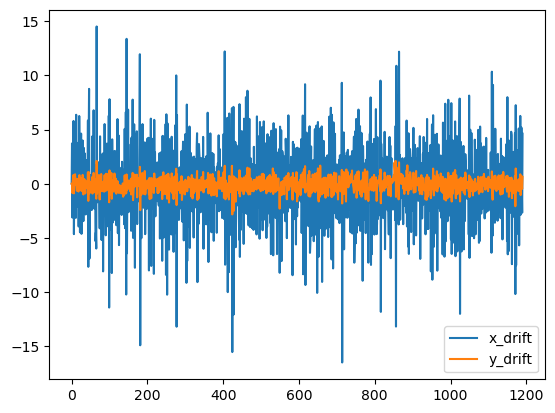

In [13]:
plt.clf()
plt.plot(x, label = 'x_drift')
plt.plot(y, label = 'y_drift')
#plt.vlines(chunks, ymin = -500, ymax = 0, label = 'reset points', color = 'g')
plt.legend(loc="lower right")
plt.show()

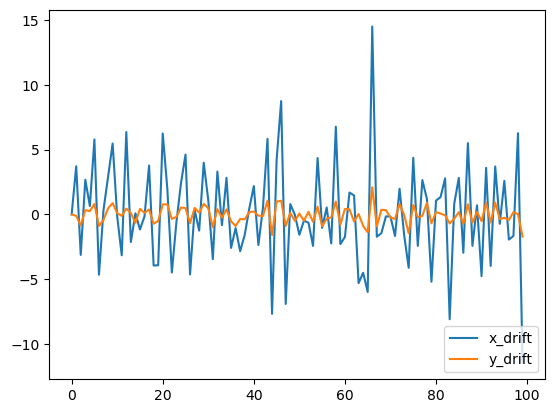

In [12]:
plt.clf()
plt.plot(x[0:100], label = 'x_drift')
plt.plot(y[0:100], label = 'y_drift')
#plt.vlines(chunks, ymin = -500, ymax = 0, label = 'reset points', color = 'g')
plt.legend(loc="lower right")
plt.show()

# testing iterative on another dataset

In [15]:
pos = 'Pos0'

In [16]:
image_path = '/home/nathan/data/kraken/ras/ND0010/Pos0/Pos0_images'

In [17]:
transform = tra_mat

x, y =transform[:,0,2], transform[:,1,2]

import matplotlib.pyplot as plt

plt.clf()
plt.plot(x, label = 'x_drift')
plt.plot(y, label = 'y_drift')
#plt.vlines(chunks, ymin = -500, ymax = 0, label = 'reset points', color = 'g')
plt.legend(loc="lower right")
plt.show()images = DaskOctopusLiteLoader(image_path, remove_background = False)


In [23]:
sr = StackReg(StackReg.TRANSLATION)
tra_mat = np.zeros((len(images['gfp']), 3, 3))
for n, frame in tqdm(enumerate(images['gfp'][0:150]), total = 150):
    if n == len(images['gfp'])-1:
        break
    tra_mat[n+1] = sr.register(images['gfp'][n], images['gfp'][n+1])
    print(n+1, tra_mat[n+1,0,2], tra_mat[n+1,1,2])

  0%|          | 0/150 [00:00<?, ?it/s]

1 -4.458869990215703 -0.15437830314431267
2 2.590623774544383 0.8357835747716535
3 -0.4517805153310519 0.4268687494632104
4 0.7679472800176654 0.3051422555474801
5 -0.0004619342814748961 0.32252759750724636
6 3.017317488416211 0.22989452923366116
7 -2.772679739545879 0.7015744516069162
8 0.8314185332085344 -0.9493291799400367
9 4.136365100264356 1.002072198968449
10 2.538447591481372 0.3914579386897685
11 -0.8064384739795969 -0.31636277216807684
12 -1.2018174949847662 0.33560647279978184
13 21.255177314834782 1156.5108739880363
14 0.4955629985663563 1.0004598473115038
15 0.7901690413179949 1.1444858088592582
16 -55.234139630897516 -333.9990673191223
17 4.689448258220523 -1.1732697701597772
18 -0.9085331219074533 1.0284527790603306
19 3.3028436090537525 1.9219982863668292
20 -2.9257864460748806 0.8269245695848895
21 -1.2428045167505388 0.3857352597985937
22 2.8481731340012857 1.3788807545104191
23 1.195254020373227 0.7515287447954506
24 -0.5263660601909805 -0.21406104821073768
25 -1.002

In [24]:
transform = tra_mat

In [25]:
x, y =transform[:,0,2], transform[:,1,2]

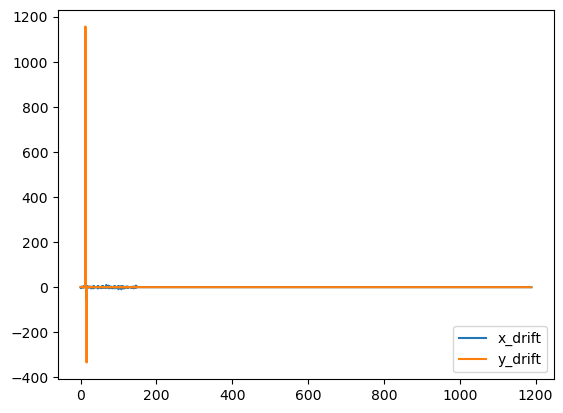

In [26]:
plt.clf()
plt.plot(x, label = 'x_drift')
plt.plot(y, label = 'y_drift')
#plt.vlines(chunks, ymin = -500, ymax = 0, label = 'reset points', color = 'g')
plt.legend(loc="lower right")
plt.show()

In [28]:
## saving out to view
np.save('/home/nathan/data/kraken/ras/ND0010/Pos0/temp_transform.npy', transform)

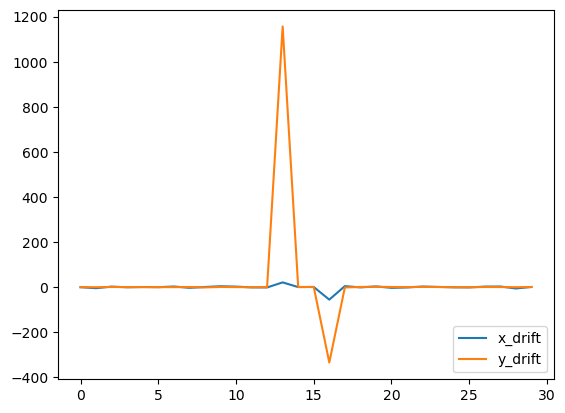

In [43]:
plt.clf()
plt.plot(x[0:30], label = 'x_drift')
plt.plot(y[0:30], label = 'y_drift')
#plt.vlines(chunks, ymin = -500, ymax = 0, label = 'reset points', color = 'g')
plt.legend(loc="lower right")
plt.show()

In [34]:
y[13]

1156.5108739880363

# still get this bizarre massive jump if we iteratively calculate 

In [36]:
image_path

'/home/nathan/data/kraken/ras/ND0010/Pos0/Pos0_images'

# testing to see if the above massive jump is frame related

In [40]:
images = DaskOctopusLiteLoader(image_path, remove_background = True)


In [41]:
for n, image in enumerate(images['gfp']):
    print(n, np.mean(image).compute())
    if n == 20:
        break

/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


0 19.074863


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


1 48.330357


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


2 32.49105


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


3 19.285557


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


4 42.119625


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


5 18.948267


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


6 43.0889


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


7 19.269049


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


8 54.91015


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


9 48.92274


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


10 22.806292


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


11 53.83953


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


12 19.324232


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


13 10.82101


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


14 50.305416


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


15 18.224634


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


16 25.197742


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


17 18.831972


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


18 17.728924


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


19 41.755577
20 18.426626


/home/nathan/analysis/octopuslite-reader/octopuslite/reader.py:147: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


In [37]:
for n, image in enumerate(images['gfp']):
    print(n, np.mean(image).compute())
    if n == 20:
        break

0 58.90509802924928
1 60.12038116253961
2 60.24917534843939
3 60.59072525519504
4 60.64431577582097
5 60.63700214181553
6 60.76318609958215
7 60.72696803401666
8 60.62204492554474
9 60.611316568047336
10 60.589749432120925
11 60.667020860792505
12 60.87459950503379
13 15.535162055862475
14 53.070182580134045
15 57.07198174023388
16 52.18430480383634
17 49.74215617025155
18 52.29480460753246
19 55.557460949549906
20 56.30829173560672


# testing diff parameters for frame removal

In [44]:
def image_generator(files, crop = None):
    """
    Generator function for iterative procesessing of image files
    """
    
    if crop is None:
        for filename in files:
            img = imread(filename)
            yield img
    else:
        for filename in files:
            img = imread(filename)
            img = crop_image(img, crop)
            yield img

In [48]:
for n, image in enumerate(image_generator(images.files('gfp'))):
    print(n, np.mean(image), image.dtype)
    if n == 20:
        break

0 58.90509802924928 uint8
1 60.12038116253961 uint8
2 60.24917534843939 uint8
3 60.59072525519504 uint8
4 60.64431577582097 uint8
5 60.63700214181553 uint8
6 60.76318609958215 uint8
7 60.72696803401666 uint8
8 60.62204492554474 uint8
9 60.611316568047336 uint8
10 60.589749432120925 uint8
11 60.667020860792505 uint8
12 60.87459950503379 uint8
13 15.535162055862475 uint8
14 53.070182580134045 uint8
15 57.07198174023388 uint8
16 52.18430480383634 uint8
17 49.74215617025155 uint8
18 52.29480460753246 uint8
19 55.557460949549906 uint8
20 56.30829173560672 uint8


In [49]:
image

array([[235, 170,  59, ...,  50,  48,  44],
       [ 52,  51,  51, ...,  47,  44,  48],
       [ 54,  52,  53, ...,  49,  44,  47],
       ...,
       [ 34,  34,  36, ...,  37,  35,  34],
       [ 34,  36,  38, ...,  35,  35,  35],
       [ 31,  31,  33, ...,  32,  33,  32]], dtype=uint8)

# !!! giulias parameters are for uint8 images so the minimum of 2 is for a range of 0,255

... but thats how the image gen loads them... has that always been the case or is there a few errant examples?

In [52]:

%%time
# pixel range criteria
max_pixel, min_pixel = 200, 20
# set empty dict arrays for mean values 
mean_arrays = {}
# set for dodgy frames (only unique entries)
dodgy_frame_list = set([])
#iterate over channels
for channel in tqdm(images.channels, desc = f'Finding mean values of image channels', total = 5):
    if channel.name == 'mask':
        continue
    # find mean value of each frame in each channel
    mean_arrays[channel.name] = [np.mean(img) for img in image_generator(images.files(channel.name))]
    # iterate over frames
    for frame, mean_value in (enumerate(mean_arrays[channel.name])):
        # check to see if mean frame pixel value meets criteria
        if max_pixel < mean_value or mean_value < min_pixel:
            # if so add to delete list
            dodgy_frame_list.add(frame)
# format delete list to only include single values
dodgy_frame_list = list(dodgy_frame_list)
print('Number of under/over-exposed frames:', len(dodgy_frame_list))

Finding mean values of image channels:   0%|          | 0/5 [00:00<?, ?it/s]

Number of under/over-exposed frames: 1190
CPU times: user 20.5 s, sys: 7.57 s, total: 28.1 s
Wall time: 9min 16s
